### Importing Libraries

In [ ]:
from PIL import Image
import os
import numpy as np
from numpy import cov, asarray
from pathlib import Path
from itertools import chain
import torch
from numpy import trace

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

### Preparing the Training Set

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(len(train_images), 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

4422102/4422102 [==============================] - 1s 0us/step


### The Generator and Discriminator Sub-Networks

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Hyper-parameters

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
EPOCHS = 60
global num_examples_to_generate
num_examples_to_generate = 64
noise_dim = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

### Training the Generator and Discriminator

In [ ]:
@tf.function
def train_step(images, batch_size):

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss + disc_loss)

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs, batch_size):
    for epoch in range(epochs):
        loss = 0
        batch_num = 0
        for image_batch in dataset:
            epoch_loss = train_step(image_batch, batch_size)
            loss += epoch_loss
            batch_num += 1
        print("Epoch:\t", epoch, "\tLoss:\t", round((loss.numpy() / batch_num), 4))
    # display.clear_output(wait=True)

In [ ]:
print(len(train_dataset))
print(len(train_images))

468
60000


In [ ]:
train_np = np.stack(list(train_dataset))
print(type(train_np))
print("Batched data sets: ", train_np.shape)

<class 'numpy.ndarray'>
Batched data sets:  (468, 128, 28, 28, 1)


In [ ]:
start_time = time.time()
train(dataset = train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE)
end_time = time.time()
train_time = end_time - start_time
print("Training time: ", train_time)

Epoch:	 0 	Loss:	 2.0182
Epoch:	 1 	Loss:	 2.1211
Epoch:	 2 	Loss:	 2.1422
Epoch:	 3 	Loss:	 2.1449
Epoch:	 4 	Loss:	 2.1508
Epoch:	 5 	Loss:	 2.126
Epoch:	 6 	Loss:	 2.1413
Epoch:	 7 	Loss:	 2.1537
Epoch:	 8 	Loss:	 2.1785
Epoch:	 9 	Loss:	 2.261
Epoch:	 10 	Loss:	 2.3642
Epoch:	 11 	Loss:	 2.4679
Epoch:	 12 	Loss:	 2.4474
Epoch:	 13 	Loss:	 2.5007
Epoch:	 14 	Loss:	 2.4356
Epoch:	 15 	Loss:	 2.4008
Epoch:	 16 	Loss:	 2.4273
Epoch:	 17 	Loss:	 2.4551
Epoch:	 18 	Loss:	 2.4355
Epoch:	 19 	Loss:	 2.4996
Epoch:	 20 	Loss:	 2.4996
Epoch:	 21 	Loss:	 2.4731
Epoch:	 22 	Loss:	 2.3855
Epoch:	 23 	Loss:	 2.3992
Epoch:	 24 	Loss:	 2.3998
Epoch:	 25 	Loss:	 2.3963
Epoch:	 26 	Loss:	 2.3788
Epoch:	 27 	Loss:	 2.3953
Epoch:	 28 	Loss:	 2.4725
Epoch:	 29 	Loss:	 2.3819
Epoch:	 30 	Loss:	 2.3485
Epoch:	 31 	Loss:	 2.3251
Epoch:	 32 	Loss:	 2.3462
Epoch:	 33 	Loss:	 2.327
Epoch:	 34 	Loss:	 2.3536
Epoch:	 35 	Loss:	 2.3197
Epoch:	 36 	Loss:	 2.3055
Epoch:	 37 	Loss:	 2.311
Epoch:	 38 	Loss:	 2.2971


### Inference Step

In [ ]:
def generate_and_save_images(model, test_input, epoch, batch_size, input_index, save, show):
    start_time = time.time()
    predictions = model(test_input, training=False)
    end_time = time.time()
    exe_time = end_time - start_time
    # path_to_save = "/content/gdrive/MyDrive/Machine Learning Course Projects"

    # if output_images.get((epoch, batch_size)) == None:
    #   output_images[(epoch, batch_size)] = predictions
    # else:
    #   if input_index < 8:
    #     curr = output_images.get((epoch, batch_size))
    #     output_images[(epoch, batch_size)] = tf.concat(axis=0, values = [curr, predictions])

    global fid_score_list
    if len(fid_score_list) == 0:
        fid_score_list = predictions
    elif len(fid_score_list) > 0:
        fid_score_list = np.append(fid_score_list, predictions, axis = 0)

    # if save == True:
    #   for i in range(predictions.shape[0]):
    #       plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
    #       plt.axis('off')
          # image_name = path_to_save + '/'+str(epoch)+"_"+str(batch_size)+"_label_"+str(i)+"_"+ str(input_index) +".png"
          # plt.savefig(image_name)
    if show == True:
        dim = int(num_examples_to_generate**0.5)
        fig = plt.figure(figsize=(dim,dim))
        for i in range(predictions.shape[0]):
            plt.subplot(dim, dim, i+1)
            plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
            plt.axis('off')
        plt.show()
        plt.close(fig)
    return exe_time

In [ ]:
def plot_inference_exe_time(target):
    plt.title("Inference execution times")
    plt.scatter(np.arange(0,len(target)), target)

In [ ]:
def inference_step(epochs, batch_size, index, noise, save, show):
    exe_time = generate_and_save_images(generator, noise, epochs, batch_size, index, save, show)
    inference_exe_time.append(exe_time)
    if show == True:
        print("Outputs for ", epochs , " number of epochs and " , batch_size, " batch size")
        print("execution time: " , exe_time)

In [ ]:
fid_score_list = np.array([])
inference_exe_time = []

In [ ]:
random_noises = tf.random.normal([1000, num_examples_to_generate, noise_dim])

In [ ]:
print(random_noises.shape)

(1000, 64, 100)


### Generating Samples

In [ ]:
print(fid_score_list.shape)

(64, 28, 28, 1)


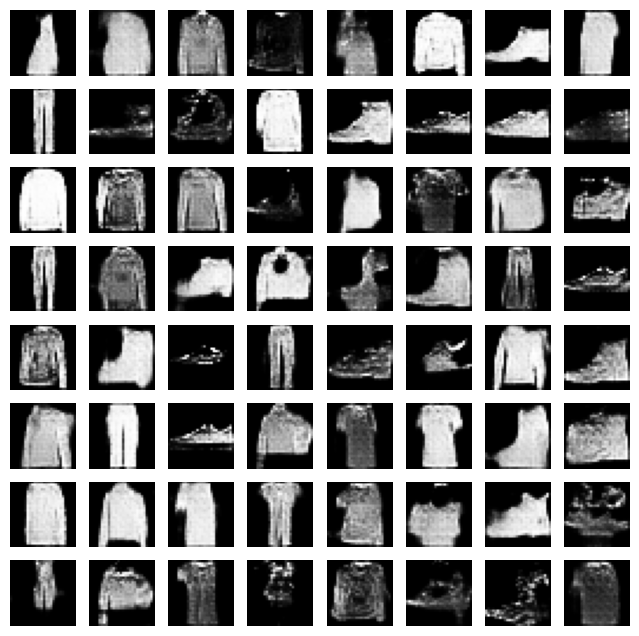

Outputs for  60  number of epochs and  128  batch size
execution time:  0.32157397270202637


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 1, random_noises[0], save = False, show = True)

In [ ]:
print("FID_score list:\t\t", fid_score_list.shape)
print("Training images:\t", train_images.shape)

FID_score list:		 (10048, 28, 28, 1)
Training images:	 (60000, 28, 28, 1)


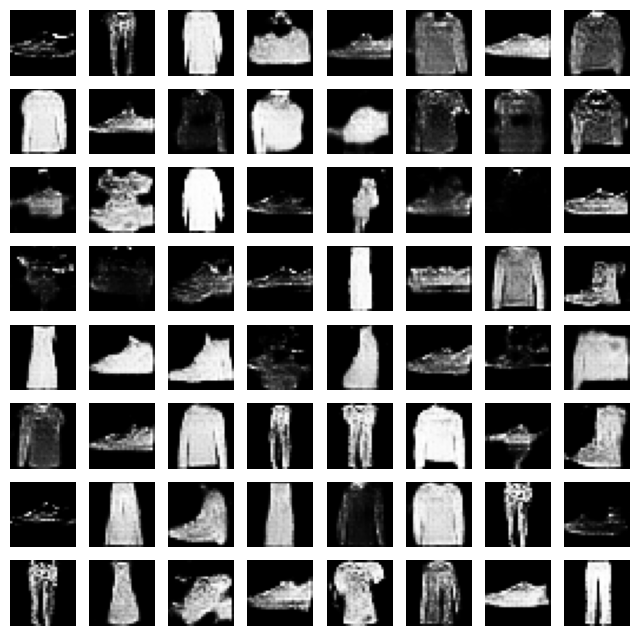

Outputs for  60  number of epochs and  128  batch size
execution time:  0.01133418083190918


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 2, random_noises[1], save = False, show = True)

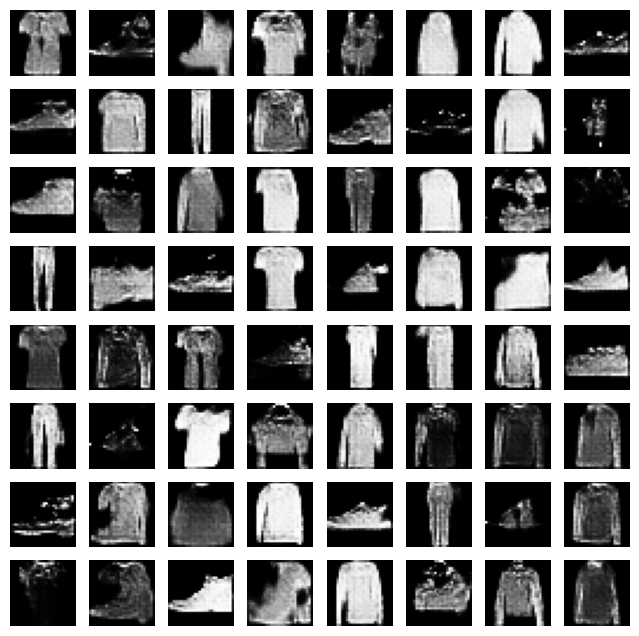

Outputs for  60  number of epochs and  128  batch size
execution time:  0.010788679122924805


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 3, random_noises[2], save = False, show = True)

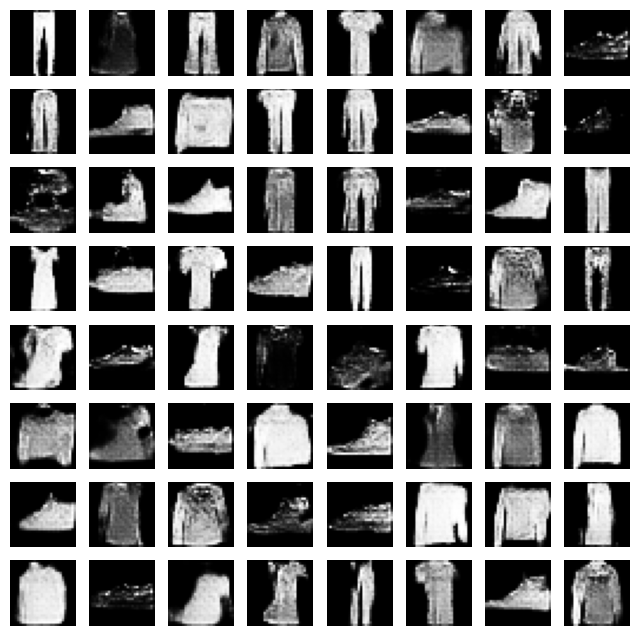

Outputs for  60  number of epochs and  128  batch size
execution time:  0.010499238967895508


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 4, random_noises[3], save = False, show = True)

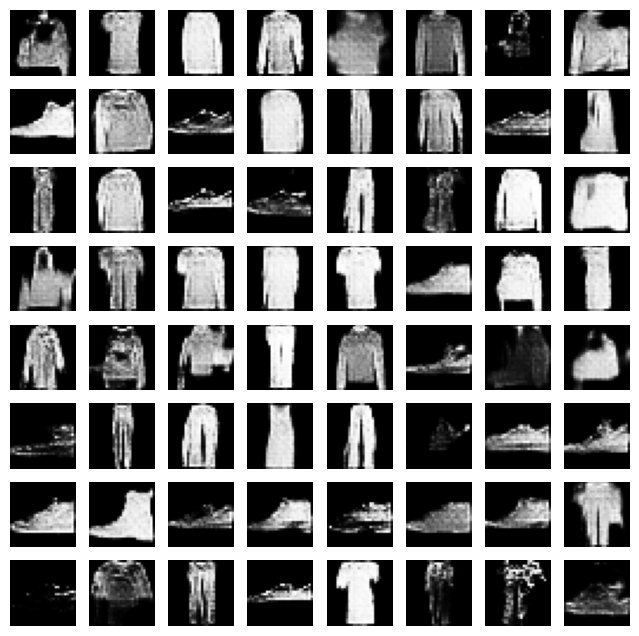

Outputs for  60  number of epochs and  128  batch size
execution time:  0.010612010955810547


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 5, random_noises[4], save = False, show = True)

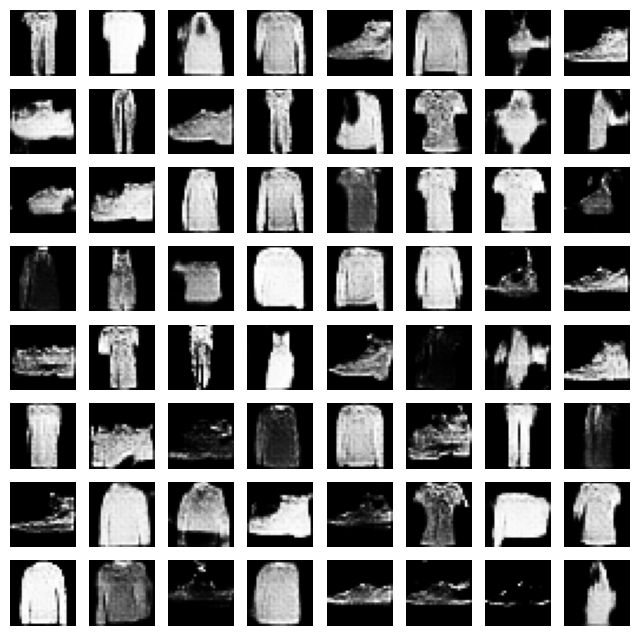

Outputs for  60  number of epochs and  128  batch size
execution time:  0.010178804397583008


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 6, random_noises[5],save = False, show = True)

In [ ]:
upperbound = int(10000/num_examples_to_generate)+2
print(upperbound)

158


In [ ]:
for t in range(1, upperbound):
    inference_step(EPOCHS, BATCH_SIZE, t,random_noises[t-1], save = False, show = False)

### Inference Step Time Execution

In [ ]:
print(len(inference_exe_time))

157


Mean inference time:  0.0101


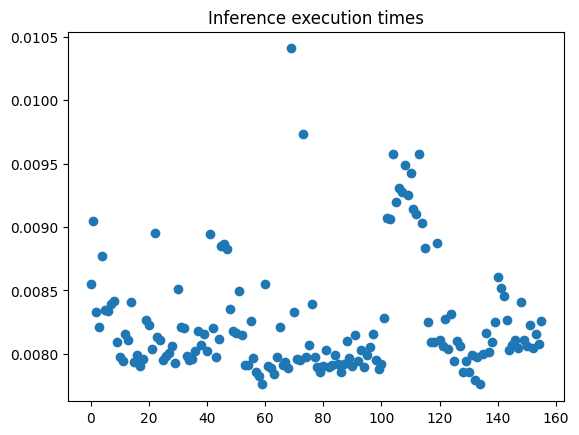

In [ ]:
## Newer
print("Mean inference time: ", round(sum(inference_exe_time)/len(inference_exe_time), 4))

## Weird thing (the first image takes a lot of time)
plot_inference_exe_time(inference_exe_time[1:])

In [ ]:
print("Mean inference time: ", round(sum(inference_exe_time)/len(inference_exe_time), 4))

Mean inference time:  0.011


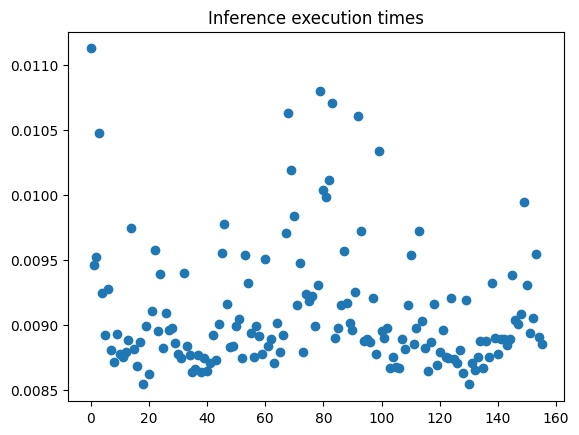

In [ ]:
## Weird thing (the first image takes a lot of time)
plot_inference_exe_time(inference_exe_time[1:])

### FID score with Inception V3

In [ ]:
print(train_images.shape)
print(fid_score_list.shape)

(60000, 28, 28, 1)
(10432, 28, 28, 1)


In [ ]:
from fid00 import FID_measure
import random
import gc

In [ ]:
gc.collect()

3844

In [ ]:
fid = FID_measure(gen_images_ = fid_score_list[:10000], train_set_ = train_images, labels_ = train_labels)
train_set_shrinked, train_labels_shrinked = fid.sample_uniformly()

Train set len :  60000
Middle of sample uniformly
Train set len :  10000
End of sample uniformly


In [ ]:
score = fid.calculate_fid()
print('FID: %.3f' % score)

train_images before preprocess:  (10000, 28, 28, 1)
gen images before preprocess:  (10000, 28, 28, 1)
train_images after scale:  (10000, 299, 299, 3)
gen images after scale:  (10000, 299, 299, 3)
train_images after preprocess:  (10000, 299, 299, 3)
gen images after preprocess:  (10000, 299, 299, 3)
313/313 [==============================] - 37s 117ms/step
Inception-V3 output for gen images:  (10000, 2048)
Inception-V3 output for train images:  (10000, 2048)
Mu1 shape:  (2048,)
Sigma1 shape:  (2048, 2048)
Mu2 shape:  (2048,)
Sigma2 shape:  (2048, 2048)
FID: 5.504


### Mean and Covariance Matrix of Train and Generated Images

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_images)

Flatten images:  (60000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(fid_score_list)

Flatten images:  (10048, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


### CNN for Predicting Generated Samples

In [ ]:
label_names = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

In [ ]:
from keras.models import load_model
cnn = load_model('CNN_fashion.h5')

In [ ]:
preds_gen = cnn.predict(fid_score_list)
pred_labels_gen = np.argmax(preds_gen, axis=1)

314/314 [==============================] - 1s 2ms/step


Frequency of Elements: 
{'Ankle boot': 900, 'Bag': 1296, 'Coat': 192, 'Dress': 2171, 'Pullover': 61, 'Sandal': 1800, 'Shirt': 1167, 'Sneaker': 1436, 'T-shirt/top': 451, 'Trousers': 574}


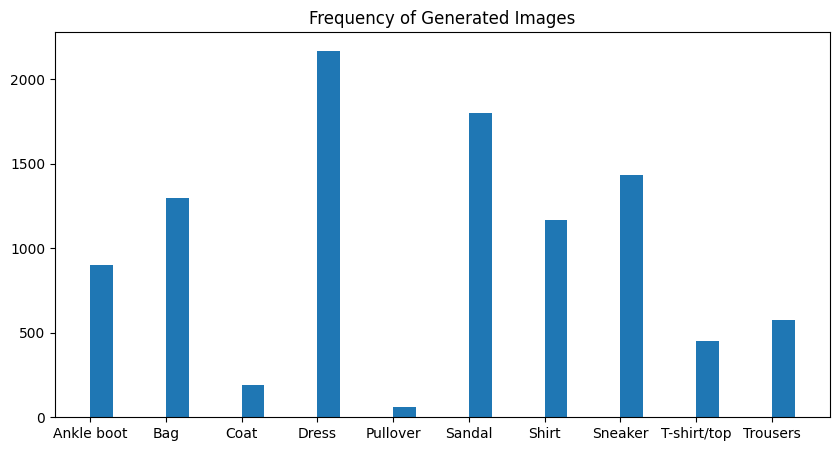

In [ ]:
## Newer
unique_elements, counts = np.unique(label_names[pred_labels_gen], return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)


plt.figure(figsize=(10, 5))
plt.bar(unique_elements, counts, align='edge', width=0.3)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

In [ ]:
unique_elements, counts = np.unique(label_names[pred_labels_gen], return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

# print(pred_labels_gen.shape)
# print(train_labels.shape)

Frequency of Elements: 
{'Ankle boot': 804, 'Bag': 1183, 'Coat': 99, 'Dress': 2021, 'Pullover': 91, 'Sandal': 1844, 'Shirt': 1449, 'Sneaker': 1313, 'T-shirt/top': 518, 'Trousers': 726}


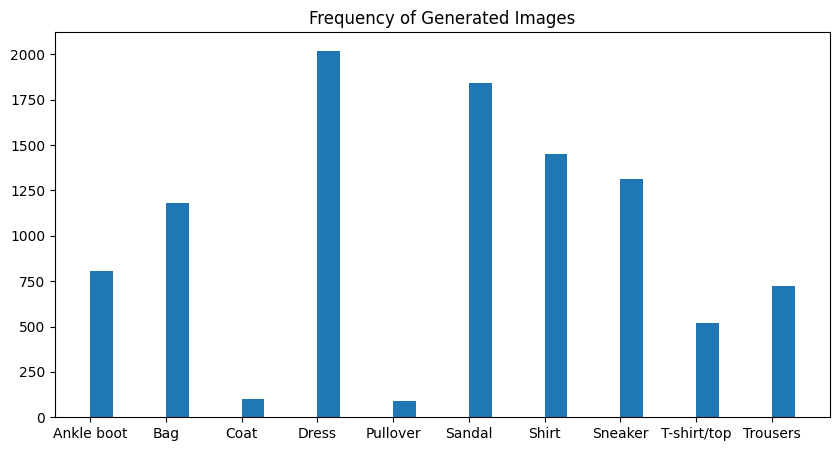

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(unique_elements, counts, align='edge', width=0.3)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

### Viewing Dimension-Reduced Samples

In [ ]:
print(vectorized_gen.shape)
print(vectorized_train.shape)

(10048, 784, 1)
(60000, 784, 1)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {label_names[class_label]}')

    plt.legend()
    plt.show()

def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    # print("Number of Components: ", pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    # plt.title("Number of Components to reach variance of " + str(variance_PCA) + " in the PCA: " + str(pca.n_components_))
    # plt.plot(np.cumsum(pca.explained_variance_ratio_))
    # plt.show()
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen[:10000], variance_PCA = 0.85)

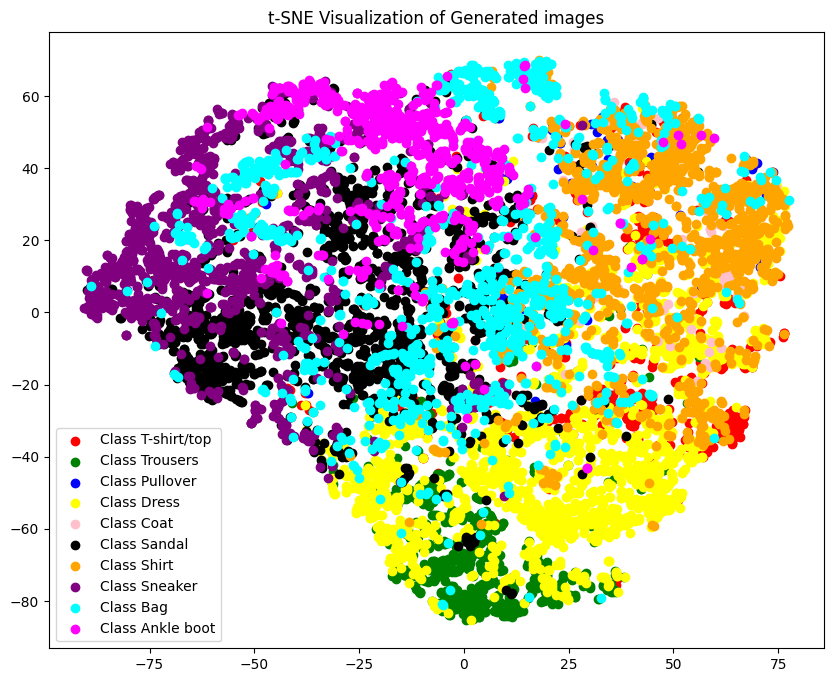

In [ ]:
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], pred_labels_gen[:10000], 't-SNE Visualization of Generated images')

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train, variance_PCA = 0.85)

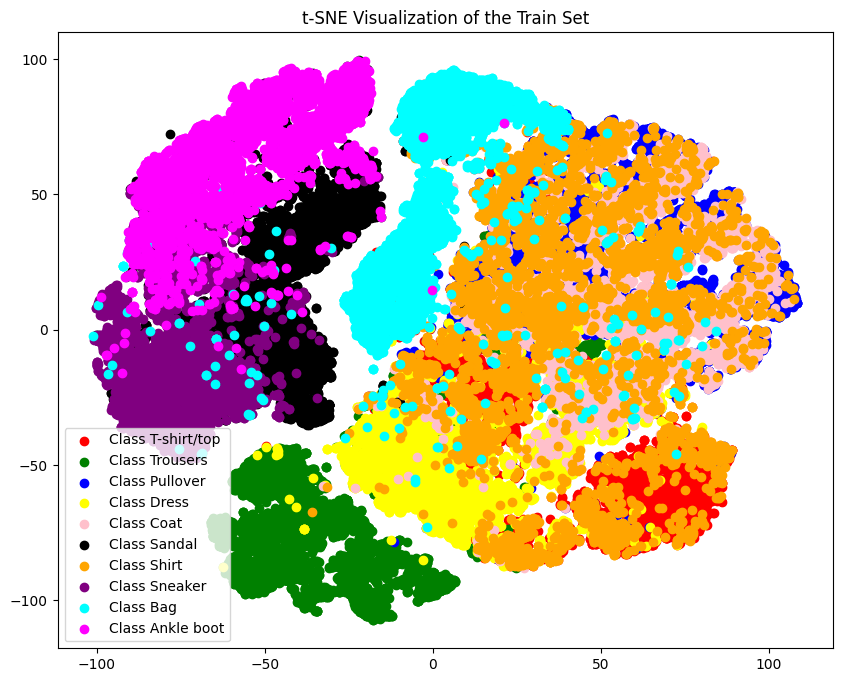

In [ ]:
scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], train_labels, 't-SNE Visualization of the Train Set')

## If the training set is not shrinked, use train_images in the calc_mu_and_sigma function and train_labels_shrinked
## instead of train_labels here

In [ ]:
print(reduced_dimension_train.shape)
print(reduced_dimension_gen.shape)

(60000, 2)
(10000, 2)


In [ ]:
gc.collect()

24792

### Precision, Recall, Density, Coverage measures

In [ ]:
_, _, vectorized_train_shrinked = calc_mu_and_sigma(train_set_shrinked)

Flatten images:  (10000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
reduced_dimension_train_shrinked = map_diversity(data = vectorized_train_shrinked, variance_PCA = 0.85)

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train_shrinked,
                          fake_features = reduced_dimension_gen,
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.6896, 'recall': 0.8135, 'density': 0.5853, 'coverage': 0.6191}

----------------------------------

10 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.7594, 'recall': 0.8748, 'density': 0.61239, 'coverage': 0.7638}

----------------------------------

6 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.711, 'recall': 0.8371, 'density': 0.5932833333333333, 'coverage': 0.6653}

----------------------------------

3 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.6081, 'recall': 0.7151, 'density': 0.5369999999999999, 'coverage': 0.4784}

----------------------------------

2 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.5048, 'recall': 0.6044, 'density': 0.48075, 'coverage': 0.3566}

----------------------------------

1 -Nearest Neighbors
Num real: 10000 Num fake: 10000
{'precision': 0.3166, 'recall': 0.3794, 'density': 0.3968, 'coverage': 0.190